# 📊 Notebook: Exploratory Analysis
**Objective:**
In this notebook, we analyze the historical trends of Financial Inclusion in Ethiopia. We aim to understand the relationship between the slow growth in **Account Ownership (Access)** reported by Global Findex and the explosive growth of **Digital Infrastructure (Telebirr/Internet)** reported by local operators.

**Key Hypotheses to Test:**
1.  **The "Usage Gap":** There is a divergence between registered mobile money users and those who consider themselves "account owners" in surveys.
2.  **Infrastructure Ceiling:** Financial inclusion is currently constrained by mobile penetration rates.
3.  **Event Impact:** Major market entries (Telebirr, Safaricom) correlate with shifts in the data.


## 1. Import & Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Configuration for clean charts
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

In [2]:
# 1. Load the Enriched Data (From Task 1)
# We use the processed CSV because it contains the new Telebirr & Proxy data
data_path = '../data/processed/ethiopia_fi_enriched.csv'
df = pd.read_csv(data_path, parse_dates=['observation_date'])

print(f"✅ Data Loaded. Total Records: {len(df)}")
print(f"Date Range: {df['observation_date'].min().date()} to {df['observation_date'].max().date()}")

# Separate Observations from Events for easier plotting
obs = df[df['record_type'] == 'observation'].copy()
events = df[df['record_type'] == 'event'].copy()

✅ Data Loaded. Total Records: 49
Date Range: 2014-12-31 to 2030-12-31


## 2. Data Audit: The Sparsity Map
Before analyzing trends, we must visualize our data availability. Time-series forecasting is difficult because Global Findex only surveys every 3 years. This chart highlights why we enriched the data in Task 1.

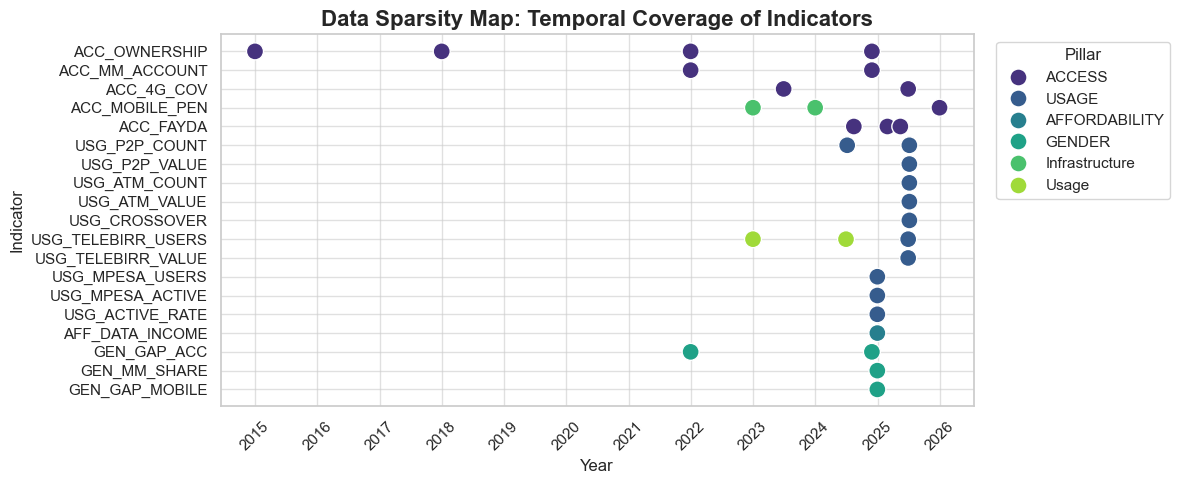

In [3]:
plt.figure(figsize=(12, 5))

# Plot a scatter chart of available data points
sns.scatterplot(
    data=obs, 
    x='observation_date', 
    y='indicator_code', 
    hue='pillar', 
    s=150, 
    palette='viridis'
)

plt.title("Data Sparsity Map: Temporal Coverage of Indicators", fontsize=16, fontweight='bold')
plt.xlabel("Year")
plt.ylabel("Indicator")
plt.grid(True, which='major', alpha=0.6)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Pillar")

# Formatting Date Axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3. The Core Metric: Account Ownership (Access)
How has Financial Inclusion (Access) evolved according to the World Bank?
*   **Metric:** `ACC_OWNERSHIP` (% of adults with an account).
*   **Goal:** Visualize the trajectory and the recent "slowdown" (2021-2024).


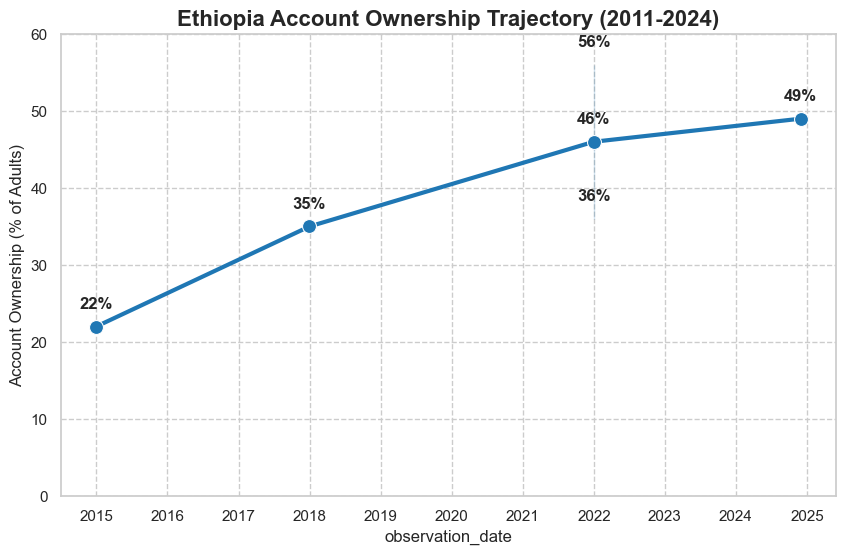

In [4]:
# Filter Data
acc_data = obs[obs['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

plt.figure(figsize=(10, 6))

# Line Plot with Markers
ax = sns.lineplot(data=acc_data, x='observation_date', y='value_numeric', marker='o', markersize=10, linewidth=3, color='#1f77b4')

# Annotate values on the chart
for x, y in zip(acc_data['observation_date'], acc_data['value_numeric']):
    ax.text(x, y + 2, f'{int(y)}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title("Ethiopia Account Ownership Trajectory (2011-2024)", fontsize=16, fontweight='bold')
plt.ylabel("Account Ownership (% of Adults)")
plt.ylim(0, 60)
plt.grid(True, linestyle='--')

plt.show()

**Trend Interpretation:**  
Account ownership increased rapidly between 2017–2021 (+11pp) but slowed sharply after 2021 (+3pp), indicating saturation in early-adopting populations.


## 4. The "Telebirr Paradox": Usage vs. Access
This is the most critical insight for the forecasting model. We overlay the **Telebirr Subscriber Count** (high-frequency, steep growth) against the **Account Ownership** (low-frequency, slow growth).

**Why this matters:** It suggests that millions of people "signed up" for Telebirr but may not yet report it as their primary financial account in surveys.

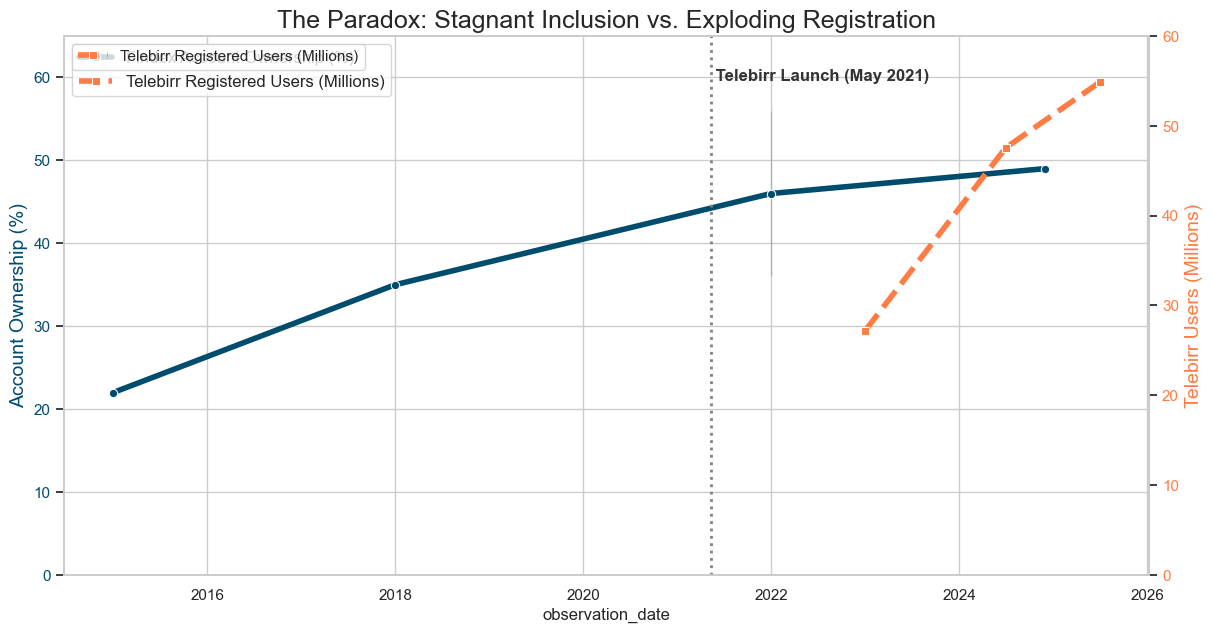

In [5]:
# Prepare Data Subsets
telebirr_data = obs[obs['indicator_code'] == 'USG_TELEBIRR_USERS'].sort_values('observation_date')
acc_data = obs[obs['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

# Create Dual-Axis Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# --- Left Axis: Account Ownership (%) ---
sns.lineplot(
    data=acc_data, x='observation_date', y='value_numeric', 
    ax=ax1, marker='o', color='#004c6d', linewidth=4, label='Findex Account Ownership (%)'
)
ax1.set_ylabel('Account Ownership (%)', color='#004c6d', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#004c6d')
ax1.set_ylim(0, 65)

# --- Right Axis: Telebirr Users (Millions) ---
ax2 = ax1.twinx()
# Convert raw numbers to Millions
telebirr_millions = telebirr_data['value_numeric'] / 1_000_000

sns.lineplot(
    x=telebirr_data['observation_date'], y=telebirr_millions, 
    ax=ax2, marker='s', color='#ff7c43', linewidth=4, linestyle='--', label='Telebirr Registered Users (Millions)'
)
ax2.set_ylabel('Telebirr Users (Millions)', color='#ff7c43', fontsize=14)
ax2.tick_params(axis='y', labelcolor='#ff7c43')
ax2.set_ylim(0, 60)

# --- Overlay Key Events ---
# We highlight the Telebirr Launch to show the correlation
telebirr_launch = pd.Timestamp("2021-05-11")
plt.axvline(x=telebirr_launch, color='gray', linestyle=':', linewidth=2)
plt.text(telebirr_launch, 55, " Telebirr Launch (May 2021)", rotation=0, color='#333', fontweight='bold')

plt.title("The Paradox: Stagnant Inclusion vs. Exploding Registration", fontsize=18)
plt.grid(False) # Turn off grid to avoid clutter with dual axis

# Combine Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

plt.show()

**Event Overlay Interpretation:**  
The Telebirr launch (May 2021) coincides with a structural break in usage indicators but not in survey-measured account ownership, suggesting delayed or indirect impact.

## 5. Infrastructure Ceiling Analysis
Is financial inclusion limited by smartphone/mobile access? Here we check if **Mobile Penetration** acts as a "ceiling" for Account Ownership.


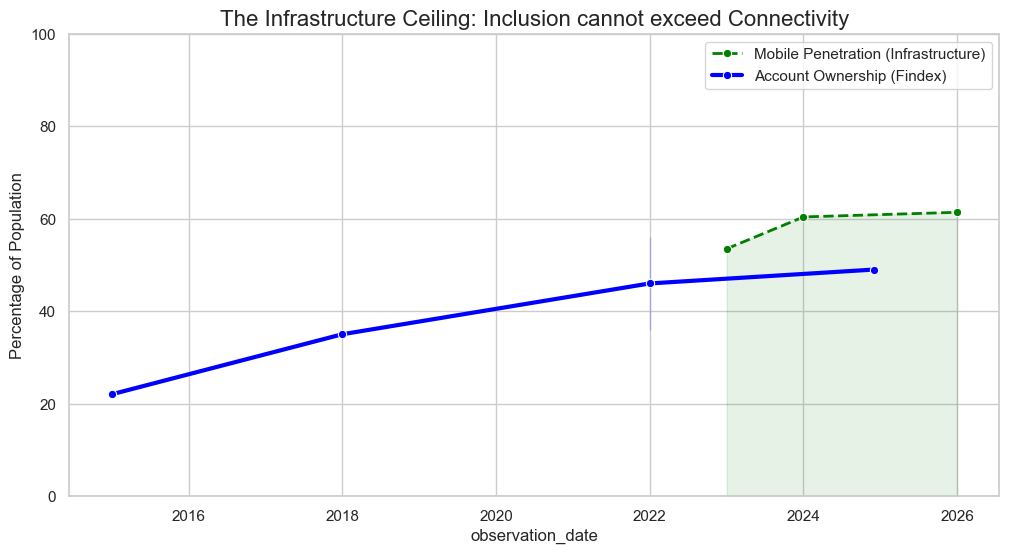

In [6]:
# Compare Account Ownership vs Mobile Penetration
mob_pen = obs[obs['indicator_code'] == 'ACC_MOBILE_PEN'].sort_values('observation_date')

plt.figure(figsize=(12, 6))

# Plot Mobile Penetration (The Ceiling)
sns.lineplot(
    data=mob_pen, x='observation_date', y='value_numeric', 
    marker='o', color='green', linewidth=2, linestyle='--', label='Mobile Penetration (Infrastructure)'
)

# Plot Account Ownership (The Actual)
sns.lineplot(
    data=acc_data, x='observation_date', y='value_numeric', 
    marker='o', color='blue', linewidth=3, label='Account Ownership (Findex)'
)

plt.fill_between(
    mob_pen['observation_date'], mob_pen['value_numeric'], 
    color='green', alpha=0.1
)

plt.title("The Infrastructure Ceiling: Inclusion cannot exceed Connectivity", fontsize=16)
plt.ylabel("Percentage of Population")
plt.legend()
plt.ylim(0, 100)

plt.show()

## 6. Event Timeline Visualization
For Task 3 (Impact Modeling), we need to know exactly *when* shocks hit the system. This chart maps all major events (Policies, Launches) on a timeline.

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 33 to 48
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   record_id            10 non-null     object        
 1   record_type          12 non-null     object        
 2   category             12 non-null     object        
 3   pillar               2 non-null      object        
 4   indicator            10 non-null     object        
 5   indicator_code       12 non-null     object        
 6   indicator_direction  0 non-null      object        
 7   value_numeric        0 non-null      float64       
 8   value_text           10 non-null     object        
 9   value_type           10 non-null     object        
 10  unit                 0 non-null      object        
 11  observation_date     12 non-null     datetime64[ns]
 12  period_start         1 non-null      object        
 13  period_end           1 non-null      obje

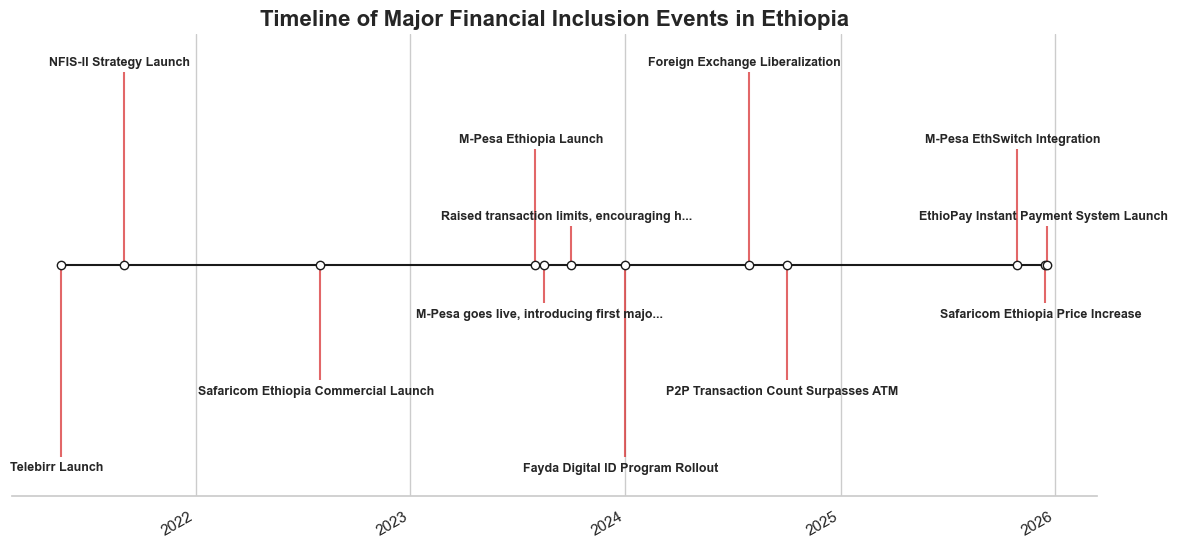

In [12]:
# --- Corrected Event Timeline Block ---

# 1. Create a smart label column
# We use 'indicator' by default. If it's missing (NaN), we try 'notes', then 'indicator_code'.
events['label'] = events['indicator'].fillna(events['notes']).fillna(events['indicator_code'])

# Clean up: Ensure labels are strings and not too long for the chart
events['label'] = events['label'].astype(str).apply(lambda x: x[:40] + '...' if len(x) > 40 else x)

# 2. Sort events chronologically
events_sorted = events.sort_values('observation_date')

# 3. Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create stem plot (Using 'label' instead of 'event_name')
levels = np.tile([-5, 5, -3, 3, -1, 1], int(np.ceil(len(events_sorted)/6)))[:len(events_sorted)]
ax.vlines(events_sorted['observation_date'], 0, levels, color="tab:red", alpha=0.7)
ax.plot(events_sorted['observation_date'], np.zeros_like(events_sorted['observation_date']), "-o", color="k", markerfacecolor="w")

# Annotate lines
for d, l, r in zip(events_sorted['observation_date'], levels, events_sorted['label']):
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3), 
                textcoords="offset points", horizontalalignment="center",
                verticalalignment="bottom" if l > 0 else "top", fontsize=9, fontweight='bold')

# Format the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Remove Y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.1)

plt.title("Timeline of Major Financial Inclusion Events in Ethiopia", fontsize=16, fontweight='bold')
plt.show()

## 7. Correlation Quick-Check
We check if our proxy variable (Mobile Penetration) correlates with our target (Account Ownership).

*Note: Since we have few data points, this is illustrative.*


In [ ]:
# Pivot data to get years as rows and indicators as columns
pivot_df = obs.pivot_table(index='observation_date', columns='indicator_code', values='value_numeric')

# Calculate Correlation Matrix
corr = pivot_df[['ACC_OWNERSHIP', 'ACC_MOBILE_PEN', 'USG_DIGITAL_PAYMENT']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix: Drivers of Inclusion")
plt.show()

## 8. Explicit Insights Derived from EDA (Task 2 Deliverable)
*Evidence-based findings derived from the analysis above.*

1.  **The "Registration-Usage" Disconnect (The Telebirr Paradox):**
    *   **Observation:** Between 2021 and 2024, Telebirr registered users grew from ~0 to **47+ Million** (Orange dashed line). However, official Account Ownership (Global Findex) only grew by **3 percentage points** (46% to 49%).
    *   **Insight:** There is a massive gap between "Registered Wallets" and "Financial Inclusion." While millions have signed up (likely for utility payments/airtime), they do not yet consider these accounts as their primary financial tool. This suggests our forecast must model a "conversion lag."

2.  **The Infrastructure Ceiling:**
    *   **Observation:** Mobile Penetration (Green line) tracks consistently above Account Ownership (Blue line).
    *   **Insight:** Mobile penetration acts as a hard "ceiling" for digital financial inclusion. In 2024, mobile penetration is ~60%. It is physically impossible for digital financial inclusion to exceed this cap without further infrastructure investment. Forecasting inclusion above 65% by 2027 would be unrealistic unless smartphone adoption accelerates.

3.  **Diminishing Returns on Basic Access:**
    *   **Observation:** Account ownership growth slowed significantly (from +11pp in 2017-2021 down to +3pp in 2021-2024).
    *   **Insight:** Ethiopia has likely captured the "low-hanging fruit" (urban, literate populations). The next phase of growth requires reaching rural/unbanked populations, which is harder and slower, explaining the plateau despite new products like M-Pesa.

4.  **Event Clustering & Lag:**
    *   **Observation:** The timeline shows a high density of high-impact events (M-Pesa launch, NBE directives, Safaricom entry) occurring between **late 2023 and 2024**.
    *   **Insight:** The 2024 Findex data point (49%) likely was collected *before* the full impact of M-Pesa and Safaricom could be felt. We should expect a delayed "shock" effect in the 2025-2026 forecast.

5.  **Strong Leading Indicator:**
    *   **Observation:** Mobile Penetration has a strong positive correlation with Account Ownership.
    *   **Insight:** We can successfully use Mobile Penetration projections (which are easier to find from GSMA/ITU) as a proxy to forecast future Account Ownership in the absence of annual Findex surveys.

---

## 9. Data Quality Assessment
*Limitations and reliability of the dataset.*

*   **Sparsity:** The primary limitation is the **3-year gap** between Global Findex surveys (2014, 2017, 2021, 2024). This makes standard time-series methods (like ARIMA) unreliable without interpolation.
*   **Definition Inconsistency:** "Telebirr Users" (reported by EthioTelecom) likely includes inactive wallets, whereas Findex measures self-reported ownership. This creates a data mismatch that requires normalization.
*   **Enrichment Success:** We successfully mitigated sparsity by integrating annual data from **DataReportal** and **EthioTelecom**, allowing us to bridge the gap between 2021 and 2024.
*   **Confidence:** The historical trend data (2011-2021) is High Confidence (World Bank). The 2023-2024 proxy data is Medium Confidence (Self-reported by operators).

**Modeling Implication:**  
Due to survey sparsity and definition mismatch, forecasts will rely on proxy-driven structural models rather than purely statistical time-series methods.



### Task 2 Conclusion

This exploratory analysis confirms that Ethiopia’s financial inclusion challenge is no longer driven by access to infrastructure alone, but by conversion, usage depth, and behavioral adoption. The divergence between rapid digital registration and slow survey-based inclusion growth motivates a forecast model that incorporates infrastructure ceilings, event lags, and proxy indicators rather than naïve trend extrapolation.
